# Imports

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [30]:
%matplotlib inline

# Config

In [3]:
BASE_PATH = "D:/projects/rahnamcollege-ml/demand-prediction"

LR_PATH_PREVIOUS = BASE_PATH + '/data/prediction/lr_result_pervious.parquet'
XGB_PATH_PREVIOUS = BASE_PATH + '/data/prediction/XGB_result_previous.parquet'


LR_PATH = BASE_PATH + '/data/prediction/lr_model_daily_result.parquet'
XGB_PATH = BASE_PATH + '/data/prediction/xgboost_model_daily_results.parquet'

LR_PATH_SPLIT = BASE_PATH + '/data/prediction/lr_model_Split_daily_result.parquet'
XGB_PATH_SPLIT = BASE_PATH + '/data/prediction/xgboost_Split_model_daily_results.parquet'


PRED_RESULT_PATH = BASE_PATH + '/data/output/Pred_Result.csv'

SPLIT_DATE = '2023-04-01'
END_DATE = '2023-05-01'


# Load Data files

In [31]:
def load_data(file_paths):
    df = pd.read_parquet(file_paths).reset_index()
    df = df.rename(columns={'real demand': 'count',
                   'predicted demand': 'pred_count'})

    return df[(df['date'] >= SPLIT_DATE) & (df['date'] < END_DATE)].sort_values(
        by=['date']).reset_index(drop=True)

In [32]:
predictions_dict = {}

models = {
    'model_xgboost_previous': {
        'file_path': XGB_PATH_PREVIOUS
    },
    'model_xgboost_newfeatures': {
        'file_path': XGB_PATH
    },
    'model_xgboost_split': {
        'file_path': XGB_PATH_SPLIT
    }
}

In [33]:
label_df = load_data(LR_PATH)
predictions_dict['baseline_last_week'] = label_df[
    ['date', 'PULocationID', 'last_week_demand']].rename(columns={'last_week_demand': 'pred_count'})


for model_name, model_info in models.items():
    df = load_data(model_info['file_path'])
    predictions_dict[model_name] = df[['date', 'PULocationID', 'pred_count']]

# Report by Metrics

### Calculate metrics for all predictions model per all LocationIDs

In [35]:
PULocationIDs = label_df['PULocationID'].unique()
PULocationIDs.sort()
metrics_all = []
for key in predictions_dict:
    for locationID in PULocationIDs:
        selected_df_model = predictions_dict[key][predictions_dict[key]['PULocationID'] == locationID]
        selected_df_actual = label_df[label_df['PULocationID'] == locationID]
        metric_mape = mean_absolute_percentage_error(
            selected_df_actual['count'], selected_df_model['pred_count'])
        metric_mae = mean_absolute_error(
            selected_df_actual['count'], selected_df_model['pred_count'])
        metric_rmse = mean_squared_error(
            selected_df_actual['count'], selected_df_model['pred_count'], squared=False)
        metrics_all.append({
            'PULocationID': locationID, 'Model': key, 'MAPE': metric_mape,'MAE': metric_mae, 'RMSE': metric_rmse})


PULocationIDs_Metrics = pd.DataFrame(metrics_all)

In [36]:
print(PULocationIDs_Metrics.shape)
PULocationIDs_Metrics.head()

(1048, 5)


,PULocationID,Model,MAPE,MAE,RMSE
0,1,baseline_last_week,0.302420,4.033333,5.076088
1,2,baseline_last_week,0.116667,0.133333,0.365148
2,3,baseline_last_week,0.707222,1.600000,1.932184
3,4,baseline_last_week,0.137036,19.200000,30.735430
4,5,baseline_last_week,0.435000,0.933333,1.183216


# Visualization

### Compare Models prediction vs. Last day count base on MAPE metric

In [37]:
def plot_model_metric(df, sorted_df, lower, upper, metrics):
    PULocationIDs_Metrics_Selected = sorted_df[sorted_df['PULocationID'].isin(
        df.iloc[lower:upper, 0])]
    PULocationIDs_Metrics_Selected = PULocationIDs_Metrics_Selected.copy()
    PULocationIDs_Metrics_Selected['PULocationID'] = PULocationIDs_Metrics_Selected[
        'PULocationID'].astype('str')
    plt.figure(figsize=(20, 5))
    sns.lineplot(data=PULocationIDs_Metrics_Selected, x='PULocationID', y=metrics, hue='Model')
    plt.xticks(rotation=90)
    plt.title(f'Show Metric {metrics} For Location Id')
    plt.show()

In [39]:
# Prepare data for sorting based on demands count
sorted_label_df = label_df.groupby('PULocationID')[['count']].mean().sort_values(
    'count', ascending=False).reset_index()
dummy = pd.Series(sorted_label_df['PULocationID']).to_frame()
PULocationIDs_Metrics_sorted = pd.merge(dummy, PULocationIDs_Metrics, on='PULocationID', how='left')

#### High Demand

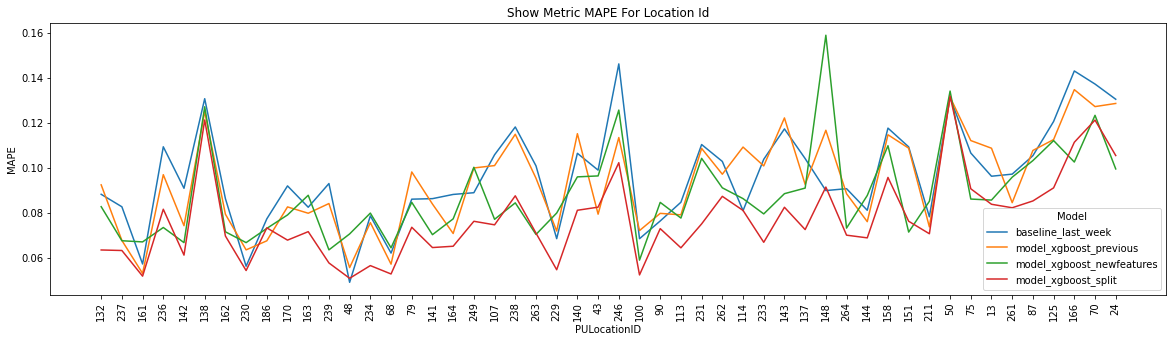

In [40]:
plot_model_metric(sorted_label_df, PULocationIDs_Metrics_sorted, 0, 50, 'MAPE')

#### Mid Demand

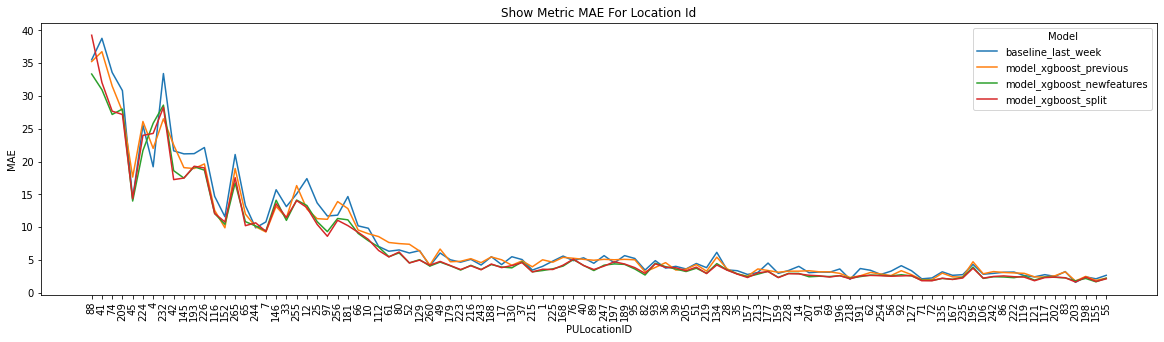

In [41]:
plot_model_metric(sorted_label_df, PULocationIDs_Metrics_sorted, 50, 150, 'MAE')

#### Low Demand

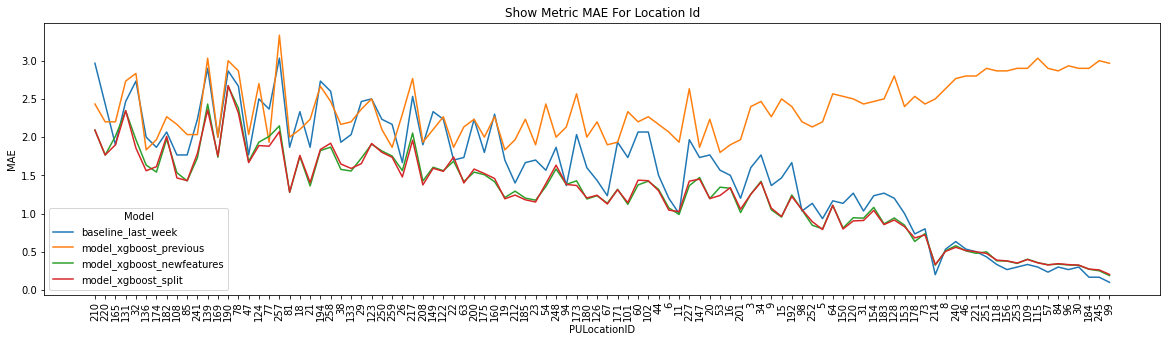

In [42]:
plot_model_metric(sorted_label_df, PULocationIDs_Metrics_sorted, 150, 250, 'MAE')

### Compare Models predicion vs. Last day count based on actual count

In [43]:
def plot_model_actual(actual_data, pred_dict, lower_bound=0, upper_bound=262):
    selected_df_model = actual_data.groupby('PULocationID')[['count']].mean().sort_values(
        'count', ascending=False).reset_index()

    selected_df_model = selected_df_model.iloc[lower_bound:upper_bound]

    plt.figure(figsize=(15, 5))
    plt.scatter(selected_df_model.index,
                selected_df_model['count'], label="Actual", color='red', s=15)
    for key in pred_dict:
        sorted_df = pd.merge(
            selected_df_model['PULocationID'], pred_dict[key], on='PULocationID', how='left')
        sorted_df = sorted_df.groupby('PULocationID')[['pred_count']].mean().sort_values(
            'pred_count', ascending=False).reset_index()
        plt.plot(selected_df_model.index, sorted_df['pred_count'], label=key)

    plt.xticks(selected_df_model.index,
               selected_df_model['PULocationID'], rotation=90)

    plt.legend()
    plt.xlabel('PULocationID')
    plt.ylabel('Counts')
    plt.title('Demand count compare models predictions vs. actual')

    plt.show()

#### High Demand

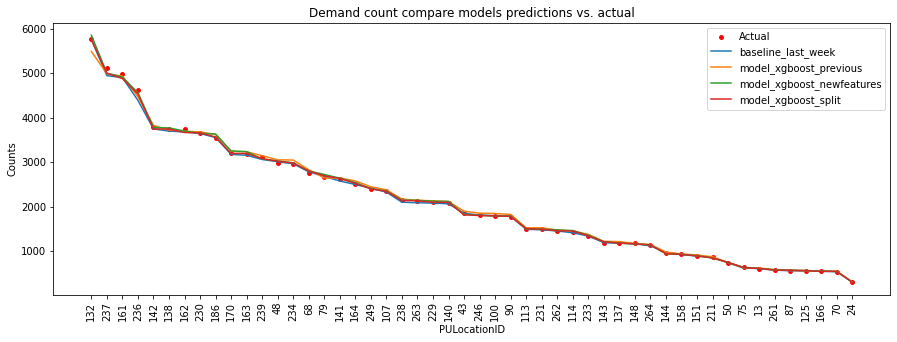

In [44]:
plot_model_actual(label_df, predictions_dict, 0, 50)

#### Mid Demand

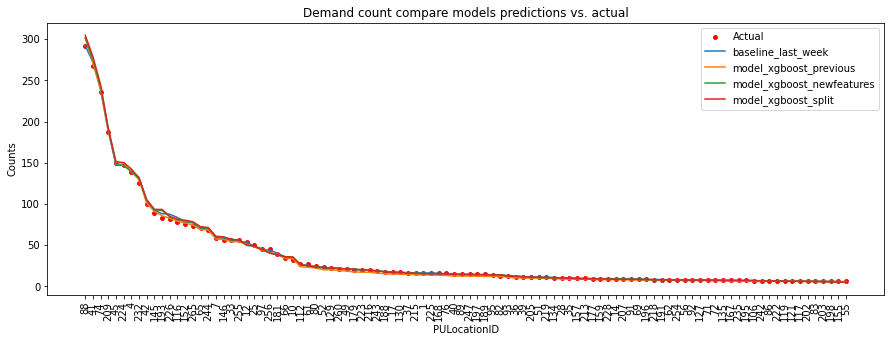

In [45]:
plot_model_actual(label_df, predictions_dict, 50, 150)

#### Low Demand

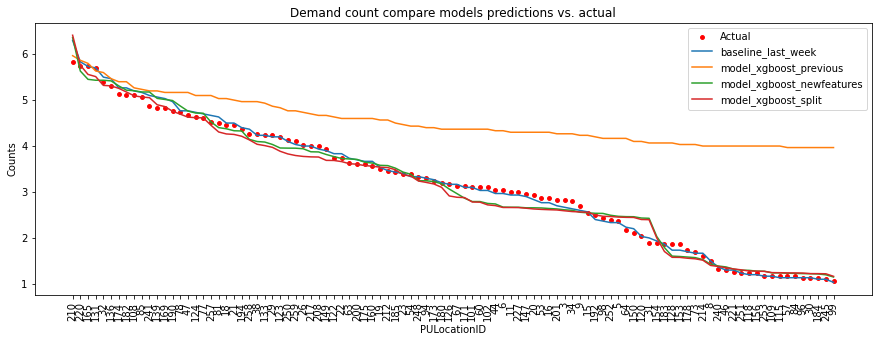

In [46]:
plot_model_actual(label_df, predictions_dict, 150, 250)

# Model prediction results in metrics

Metrics: MAPE, MAE, RMSE

In [47]:
def caculate_metrics(df, sorted_df, lower=0, upper=266):
    PULocationIDs_Metrics_Selected = sorted_df[
        sorted_df['PULocationID'].isin(df.iloc[lower:upper, 0])]
    PULocationIDs_Metrics_Selected = PULocationIDs_Metrics_Selected.copy()
    PULocationIDs_Metrics_Selected['PULocationID'] = PULocationIDs_Metrics_Selected[
        'PULocationID'].astype('str')
    predictions_result = []
    for key in predictions_dict:
        metric_mape = PULocationIDs_Metrics_Selected[PULocationIDs_Metrics_Selected['Model'] == key]['MAPE'].mean()
        metric_mae = PULocationIDs_Metrics_Selected[PULocationIDs_Metrics_Selected['Model'] == key]['MAE'].mean()
        metric_rmse = PULocationIDs_Metrics_Selected[PULocationIDs_Metrics_Selected['Model'] == key]['RMSE'].mean()
        predictions_result.append({'Model': key, f"MAPE_{lower}-{upper}": metric_mape, f"MAE_{lower}-{upper}": metric_mae, 
                                    f"RMSE_{lower}-{upper}": metric_rmse})
    return predictions_result

#### High Demand

In [48]:
df1 = pd.DataFrame(caculate_metrics(sorted_label_df, PULocationIDs_Metrics_sorted, 0, 50))

#### Mid Demand

In [49]:
df2 = pd.DataFrame(caculate_metrics(sorted_label_df, PULocationIDs_Metrics_sorted, 50, 150))

#### Low Demand

In [50]:
df3 = pd.DataFrame(caculate_metrics(sorted_label_df, PULocationIDs_Metrics_sorted, 150, 250))

Merge all the results together and sort them

In [51]:
merged_result_df = df1.merge(df2, on='Model').merge(df3, on='Model')

In [52]:
# Define a custom sorting function to extract the numeric suffix and sort the columns accordingly
def sort_columns_key(column):
    if column == 'Model':
        return (0, '')
    metric, suffix = column.split('_')
    return (1, metric, int(suffix.split('-')[0]), int(suffix.split('-')[1]))


sorted_columns = sorted(merged_result_df.columns, key=sort_columns_key)

In [53]:
predictions_result = merged_result_df[sorted_columns]

In [54]:
display(predictions_result)

,Model,MAE_0-50,MAE_50-150,MAE_150-250,MAPE_0-50,MAPE_50-150,MAPE_150-250,RMSE_0-50,RMSE_50-150,RMSE_150-250
0,baseline_last_week,188.832000,8.172000,1.559667,0.096336,0.373333,0.595934,238.915288,10.631622,2.097484
1,model_xgboost_previous,176.875333,7.805333,2.377667,0.093773,0.364834,1.320879,225.375402,10.096109,2.922882
2,model_xgboost_newfeatures,168.612750,7.016031,1.260451,0.087929,0.327890,0.512656,213.610071,9.022064,1.630510
3,model_xgboost_split,148.658488,7.072100,1.253917,0.077276,0.328988,0.504230,189.459226,9.041224,1.625328


#### Save Metrics output to File

In [55]:
predictions_result.to_csv(PRED_RESULT_PATH)